# Models Tutorial

The purpose of this notebook is to demonstrate manual coding of models used in this project, specifically autoregressive models and weighted least squares. 

In [1]:
import sys
import numpy as np
from numpy import random
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import os
import os.path as osp
import pandas as pd
from statsmodels.tsa.ar_model import AutoReg

# Custom modules
sys.path.append(osp.join(os.getcwd(),"src")) # Add src subdirectory to python path
from data_funcs import synthetic_data

In [2]:
# Generate Data
# Sim data, no rain for simplicity
random.seed(456)

hours = 400 # Total number of time steps
dat = synthetic_data(max_rain = 0, data_noise = .5)  # Sim data from FMDA project code
fm = dat['fm'][0:hours]
h=np.arange(0, hours)

# Manually edit sim data to illustrate point about ROS
fm = fm + 20 - .07*np.arange(0, hours) # Shift up by 20, add decreasing trend

# Split to training and test
# Model 1 fit with OLS on FM
h = h.reshape(-1, 1)
h2 = 300
fmtr=fm[0:h2]
fmte=fm[h2:len(fm)]

## Autoregressive Models

The `AutoReg` function from `statsmodels` provides a relatively simple interface for fitting models. However, it is not straightforward to add weights or make some other custom loss function. The point is to use the linear regression model from `sklearn`, so weights and custom loss can easily be added. 

For a few different AR models we will reproduce the results with linear regression. The mathematical form of an AR model with time lags $k=1, 2, ..., K$:

$$
y_t = \beta_0 + \sum_{k=1}^K \beta_k y_{t-k} +\epsilon_t
$$

## Lag 1 AR model with constant trend

The mathematical specification is:

$$
y_t = \beta_0 + \beta_1 y_{t-1} +\epsilon_t
$$

In [4]:
## Autoreg Model, lag 1 and default of constant trend 
ar1 = AutoReg(fmtr, lags=1).fit() # ROS is modeled response
fit1 = ar1.predict(start=0, end=h2-1, dynamic=False) # ignore NAN values at beginning when lags can't be calculated
fit1 = fit1[1:h2]  # ignore NAN values at beginning when lags can't be calculated

## Reproduce with LinearRegression, with default constant mean (same as const trend)

X = pd.DataFrame({'rs': fmtr})
X['lag1'] = X['rs'].shift(1)
X = X.drop(['rs'], axis=1)
X = X.dropna().to_numpy()

mod = LinearRegression().fit(X, np.delete(fmtr, 0))
fits = mod.predict(X)

We then compare the results up to rounding error. We expect a value close to machine epsilon, or in the $10^{-18}$ range. Additionally, the model parameters should be the same up to rounding error.

In [5]:
## Compare Results up to rounding error
def max_err(x, y):
    return np.max(np.abs(x-y))

print(f'Training Max Difference: {max_err(fits, fit1)}')

Training Max Difference: 2.842170943040401e-14


In [48]:
# Params same to 8 decimal places
print(np.round([mod.intercept_, mod.coef_[0]], 8))
print(ar1.params)

[0.17953995 0.99114216]
[0.17953995 0.99114216]


For prediction with the LM model, we have to iteratively call the predict function starting with the last observation, then moving forward one forecasted value at a time.

In [124]:
# Predict with built-in AR function
preds1 = ar1.model.predict(ar1.params, start=len(fmtr), end=len(fm)-1, dynamic=False)
# preds11 = ar1.forecast(hours-h2) # Note: equivalent

In [117]:
def predict_ts(m, f, ts):
    "m: model object"
    "f: observed"
    "ts: number of time steps to forecast"

    preds = np.zeros(ts) # initialize array of forecasts for return value
    
    Xtemp = f[-1].reshape(1, 1) # model matrix with last fitted value
    
    preds[0]=m.predict(Xtemp)

    # Loop through remaining time steps and predict using last value
    for i in range(1, ts):
        Xtemp = preds[i-1].reshape(1, 1)
        preds[i]=m.predict(Xtemp)
    
    return preds

In [118]:
preds=predict_ts(mod, fmtr, len(fm)-h2)

In [123]:
np.max(np.abs(preds - preds1)) # Expect small value

1.5205614545266144e-12

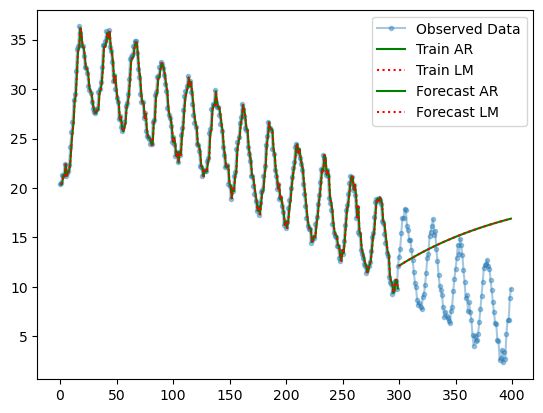

In [131]:
plt.plot(h, fm, "-o", label = "Observed Data", markersize=3, alpha=.4)
plt.plot(h[1:h2], fit1,"-g", label = "Train AR")
plt.plot(h[1:h2], fits, ":r", label = "Train LM")
plt.plot(h[h2:hours], preds1,"-g", label = "Forecast AR")
plt.plot(h[h2:hours], preds, ":r", label = "Forecast LM")
plt.legend()

This is clearly a bad model for the given data, which has a clear time trend and seasonal effect, but this is just to illustrate the inner workings.